# import libreries for the experiment

In [1]:
import sys
import os
import json
import random 

import numpy as np                                                                  
import pandas as pd
import matplotlib.pyplot as plt                                                       

import cv2                                                                         
import mediapipe as mp  

from glob import glob                                                               
from pathlib import Path                                                            
from natsort import natsorted                                                       
from tqdm.auto import tqdm 

from sklearn.model_selection import train_test_split                                                
from collections import defaultdict
from typing import Callable, List, Tuple
from numpy.typing import NDArray

import torch
from torch import nn
import torch.optim as optim                                                          
import torch.nn.functional as F 
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter 
from torchinfo import summary
    
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from captum.attr import LayerConductance

In [2]:
sys.path.append(os.path.abspath('../src'))
import prepare_datasets
import preprocessing 
import models  
import training 
import plotting
import set_train

# Getting landmarks from LSA 64 dataset

In [3]:
# define directories
# root= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/lsa64_raw/all'
# save_dir= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/SignLanguageProject/data/landmarks_lsa64'

# 30fps
# get media pipe landmarks
#result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 30)

#save media pipe landmarks
#np.save(os.path.join(save_dir, 'detections30fps.npy'), np.array(result[0]))     
#with open(os.path.join(save_dir, 'labels30fps.json'), 'w') as file:
    #json.dump(result[1], file) 

# 40fps
# get media pipe landmarks
#result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 40)

#save media pipe landmarks
#np.save(os.path.join(save_dir, 'detections40fps.npy'), np.array(result[0]))     
#with open(os.path.join(save_dir, 'labels40fps.json'), 'w') as file:
    #json.dump(result[1], file) 

# 50fps
# get media pipe landmarks
#result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 50)

#save media pipe landmarks
#np.save(os.path.join(save_dir, 'detections50fps.npy'), np.array(result[0]))     
#with open(os.path.join(save_dir, 'labels50fps.json'), 'w') as file:
    #json.dump(result[1], file)

# 60fps
# get media pipe landmarks
#result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 60)

#save media pipe landmarks
#np.save(os.path.join(save_dir, 'detections60fps.npy'), np.array(result[0]))     
#with open(os.path.join(save_dir, 'labels60fps.json'), 'w') as file:
    #json.dump(result[1], file)

# loading all saved landmarks from LSA 64 dataset

In [3]:
# defining path to project folder
root_dir= os.path.dirname(os.getcwd())

# path to dataset directories
data_dir= os.path.join(root_dir, 'data')

# path to LSA 64 landmark directory
lsa= os.path.join(data_dir, 'landmarks_lsa64')

# dictionaries to categorize labels and detections based on the fps
lsa64_labels = {'30fps': None, '40fps': None, '50fps': None, '60fps': None}
lsa64 = {'30fps': None, '40fps': None, '50fps': None, '60fps': None}

# loading detections and labels to the dictionaries
for i in [30, 40, 50, 60]:
    lsa64[f'{i}fps']= np.load(os.path.join(lsa, f'detections{i}fps.npy'), allow_pickle=True)
    with open(os.path.join(lsa, f'labels{i}fps.json'), 'r') as file:
        lsa64_labels[f'{i}fps']= json.load(file)

In [4]:
lsa64['30fps'].shape, lsa64['40fps'].shape, lsa64['50fps'].shape, lsa64['60fps'].shape

((3200, 30, 1662), (3200, 40, 1662), (3200, 50, 1662), (3200, 60, 1662))

In [5]:
len(lsa64_labels['30fps']), len(lsa64_labels['40fps']), len(lsa64_labels['40fps']), len(lsa64_labels['60fps'])

(3200, 3200, 3200, 3200)

# visualizing how interpolation works

In [7]:
video1= lsa64['60fps'][0]
video2= lsa64['60fps'][48]
ivd= preprocessing.interpolate_video_detections(video1, video2, [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)], 0.5)
video1.shape, video2.shape, ivd.shape

((60, 1662), (60, 1662), (60, 1662))

In [8]:
plotting.show_detections(ivd)

# Experiments

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #set up device to cuda
print(device)

cuda


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

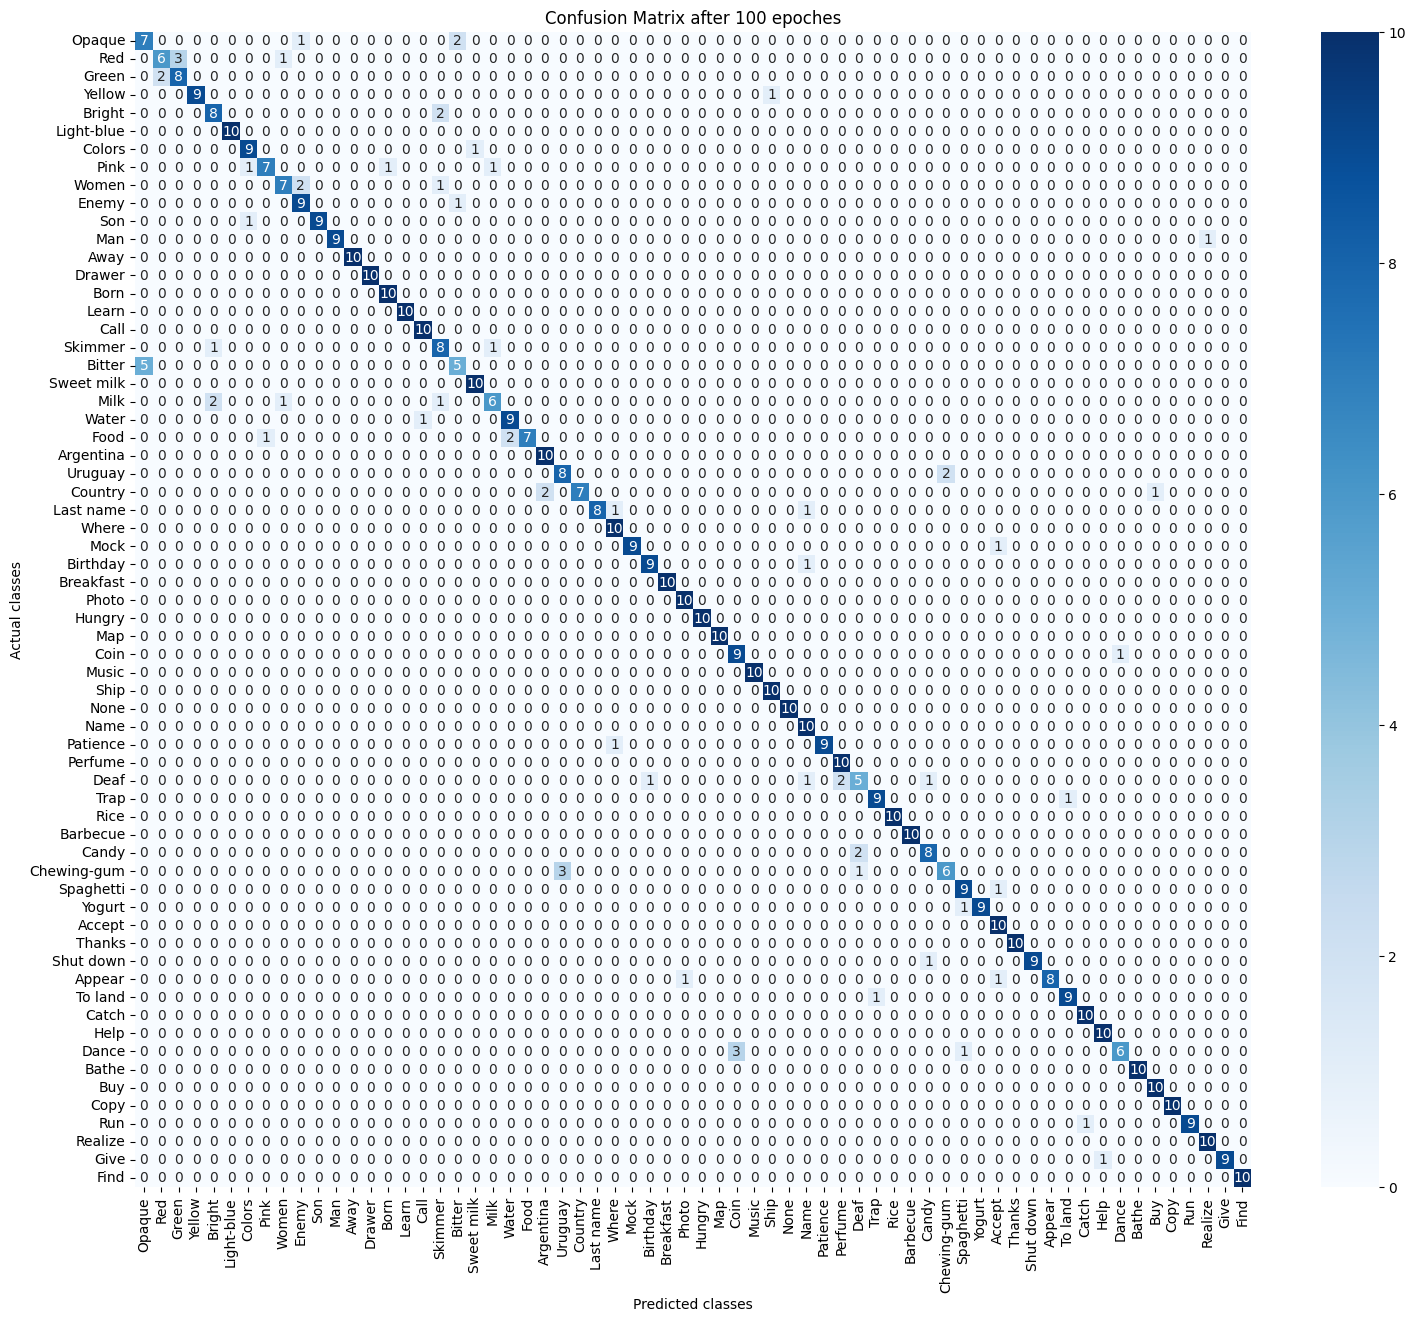

In [7]:
model= models.LstmModel(class_names= prepare_datasets.lsa64class_names, input_size= 1662, hidden_size= 277, num_layers= 1, activition= nn.ReLU())

set_train.train_parameters(detections= lsa64['30fps'],
                           labels= lsa64_labels['30fps'],
                           class_names= prepare_datasets.lsa64class_names, 
                           test_size= 0.2, 
                           random_state= 42, 
                           batch_size= 128, 
                           num_epochs= 100,
                           model= model, 
                           learning_rate= 0.0001,
                           device= device)

Fold 1
-------


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

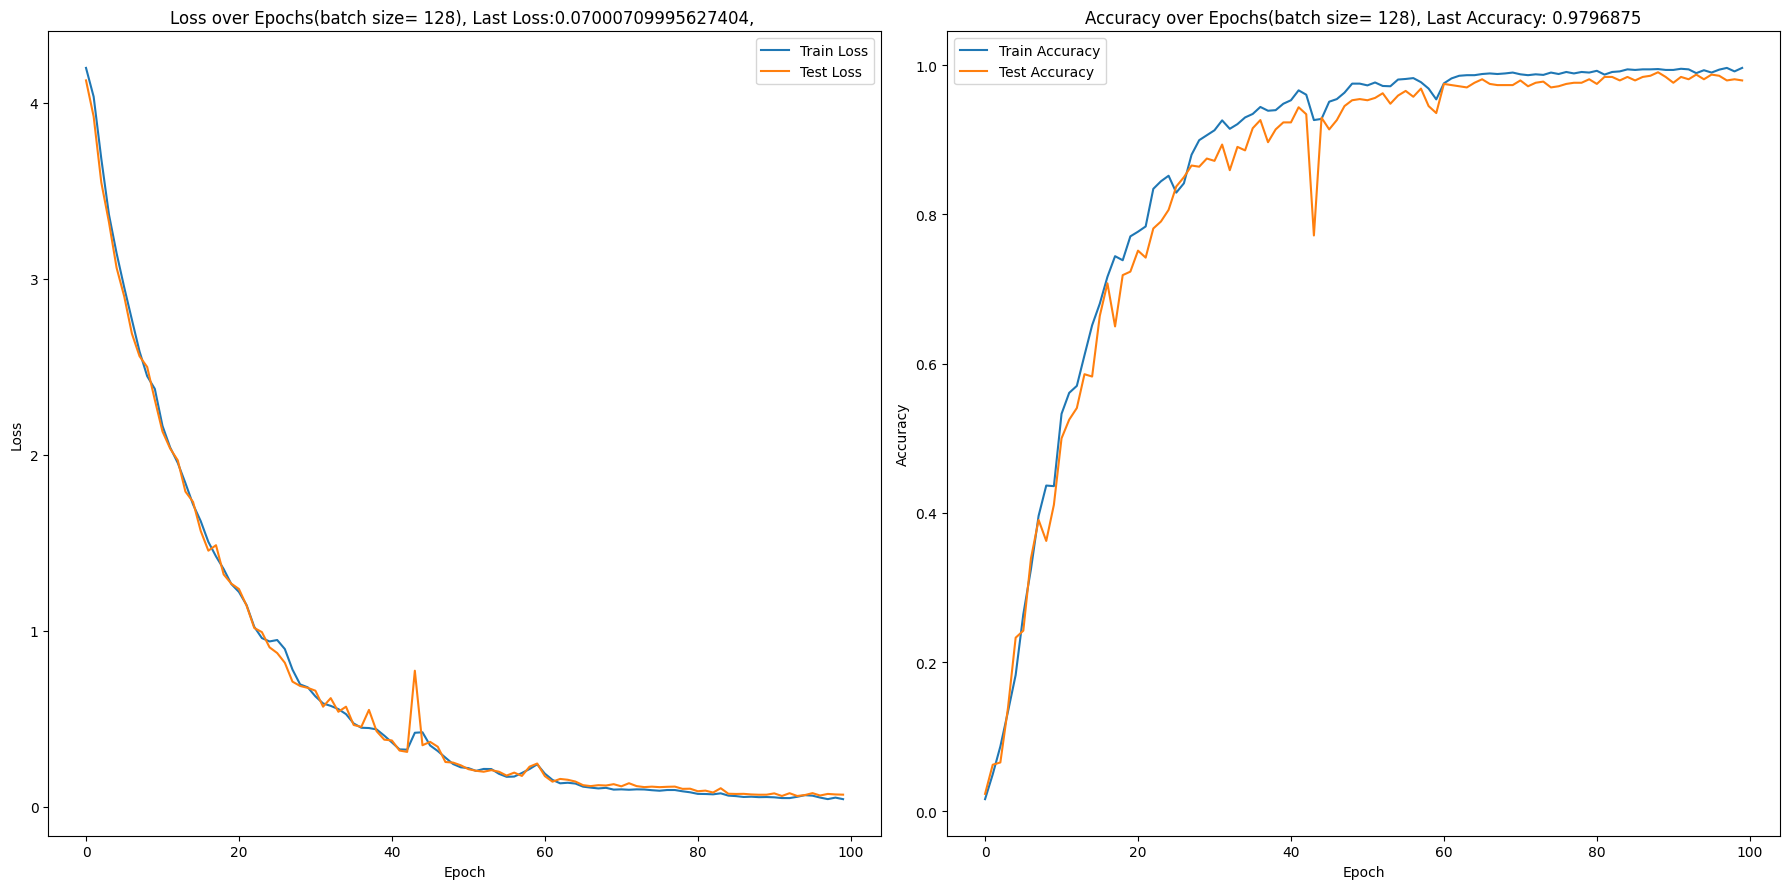

Fold 2
-------


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

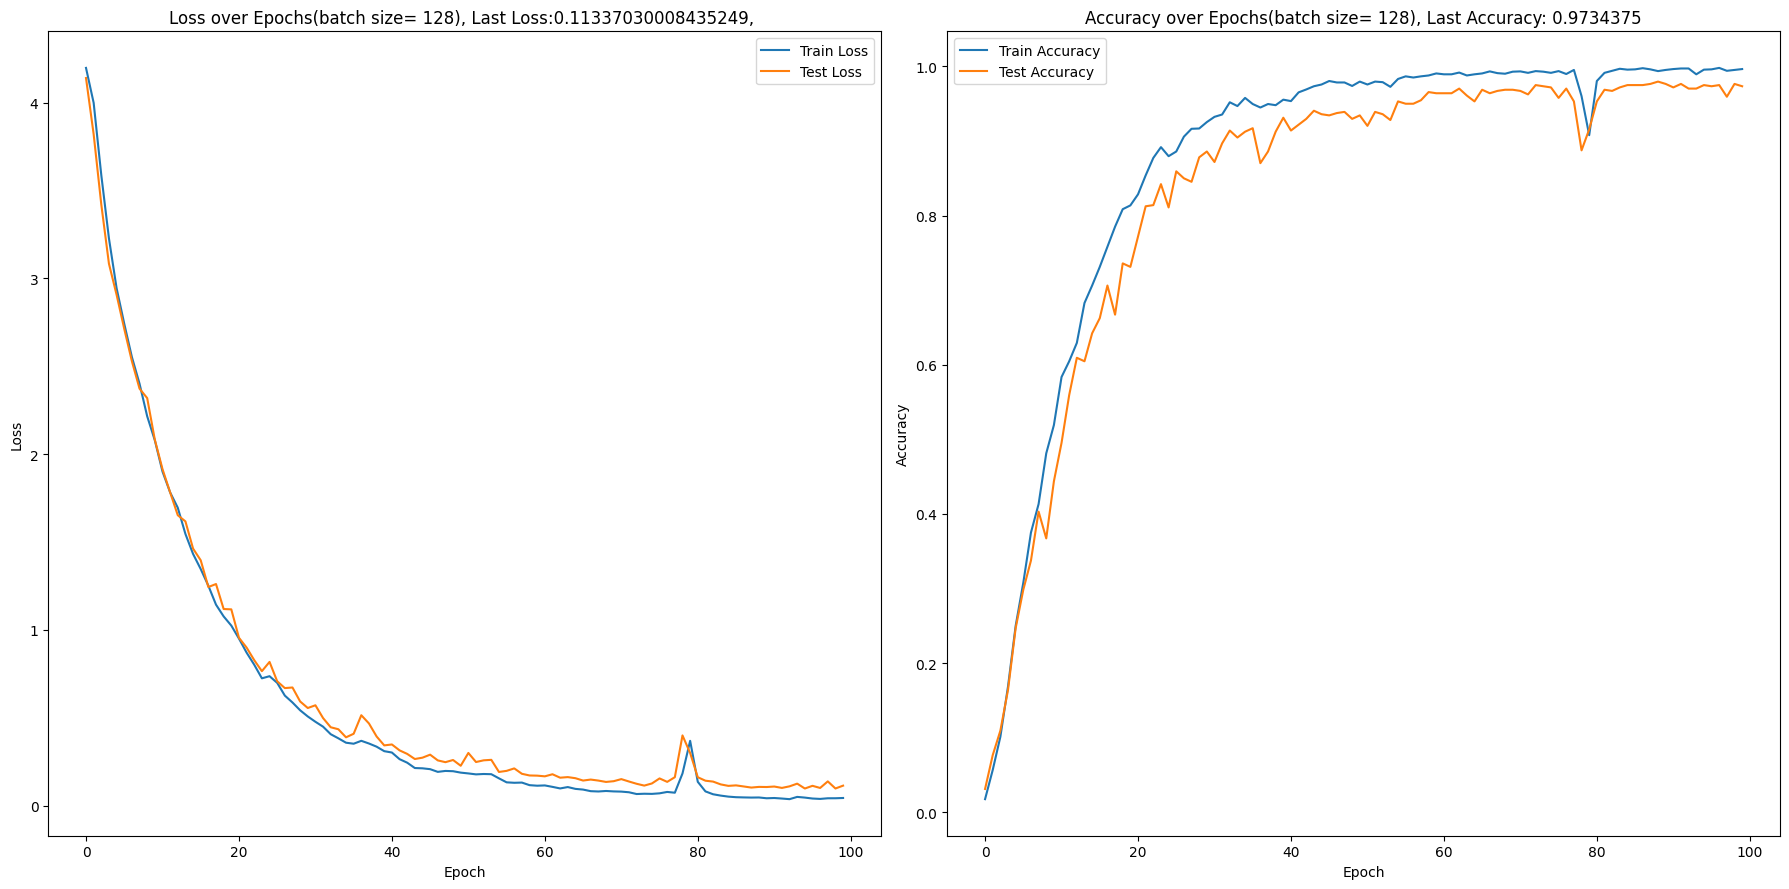

Fold 3
-------


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

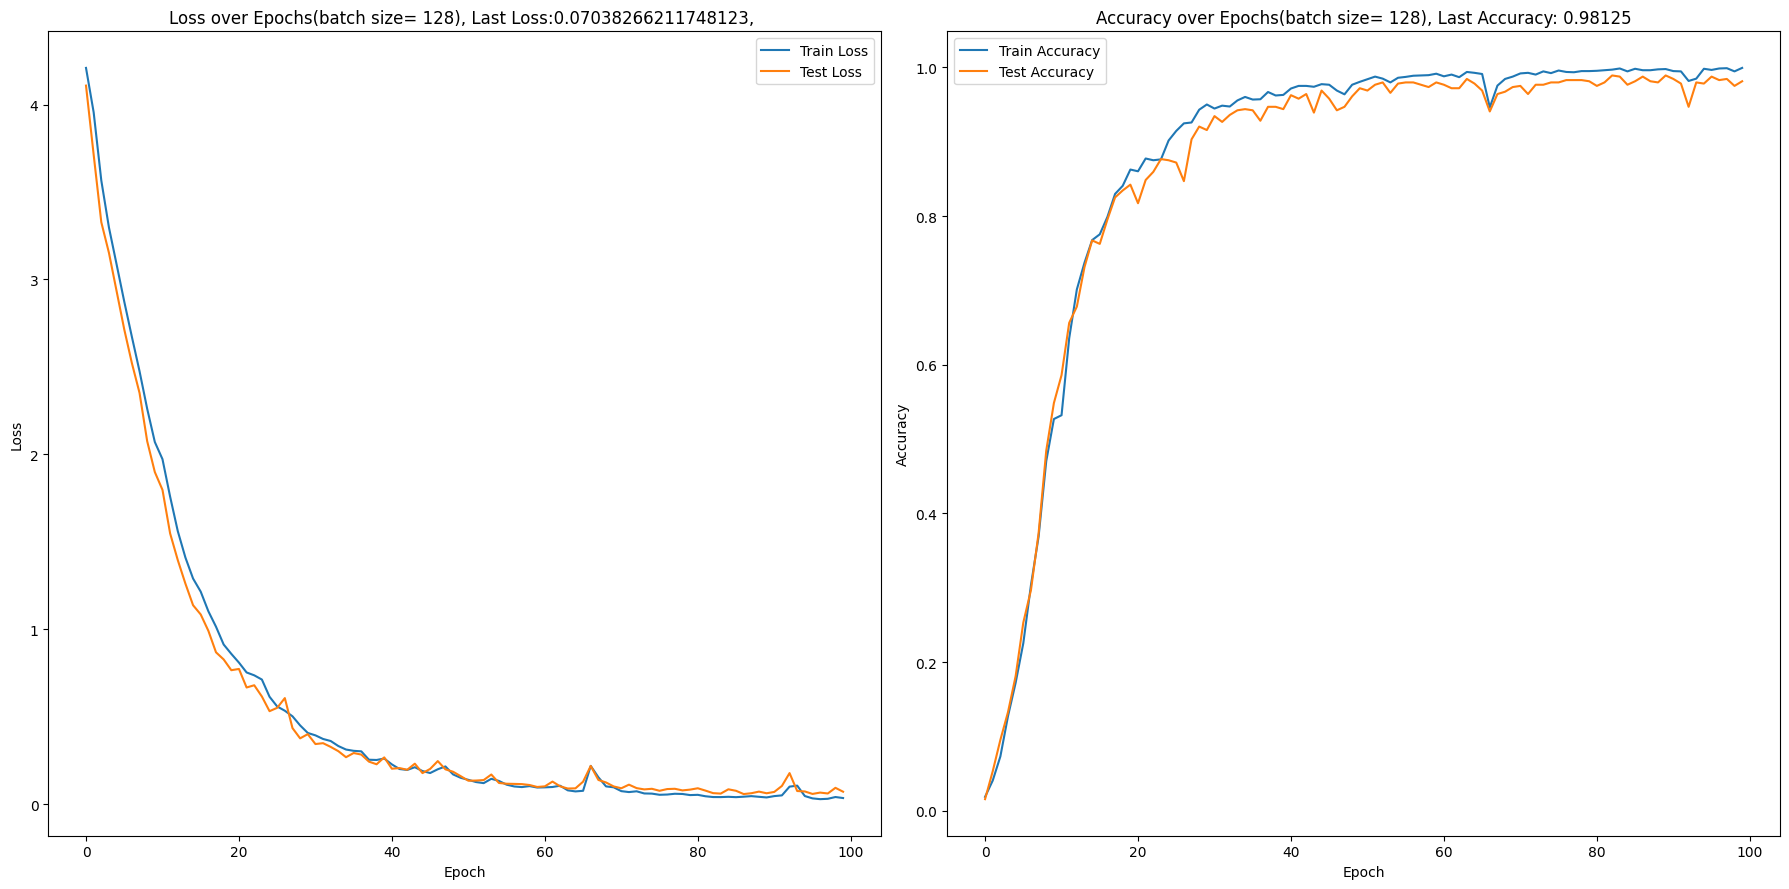

Fold 4
-------


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

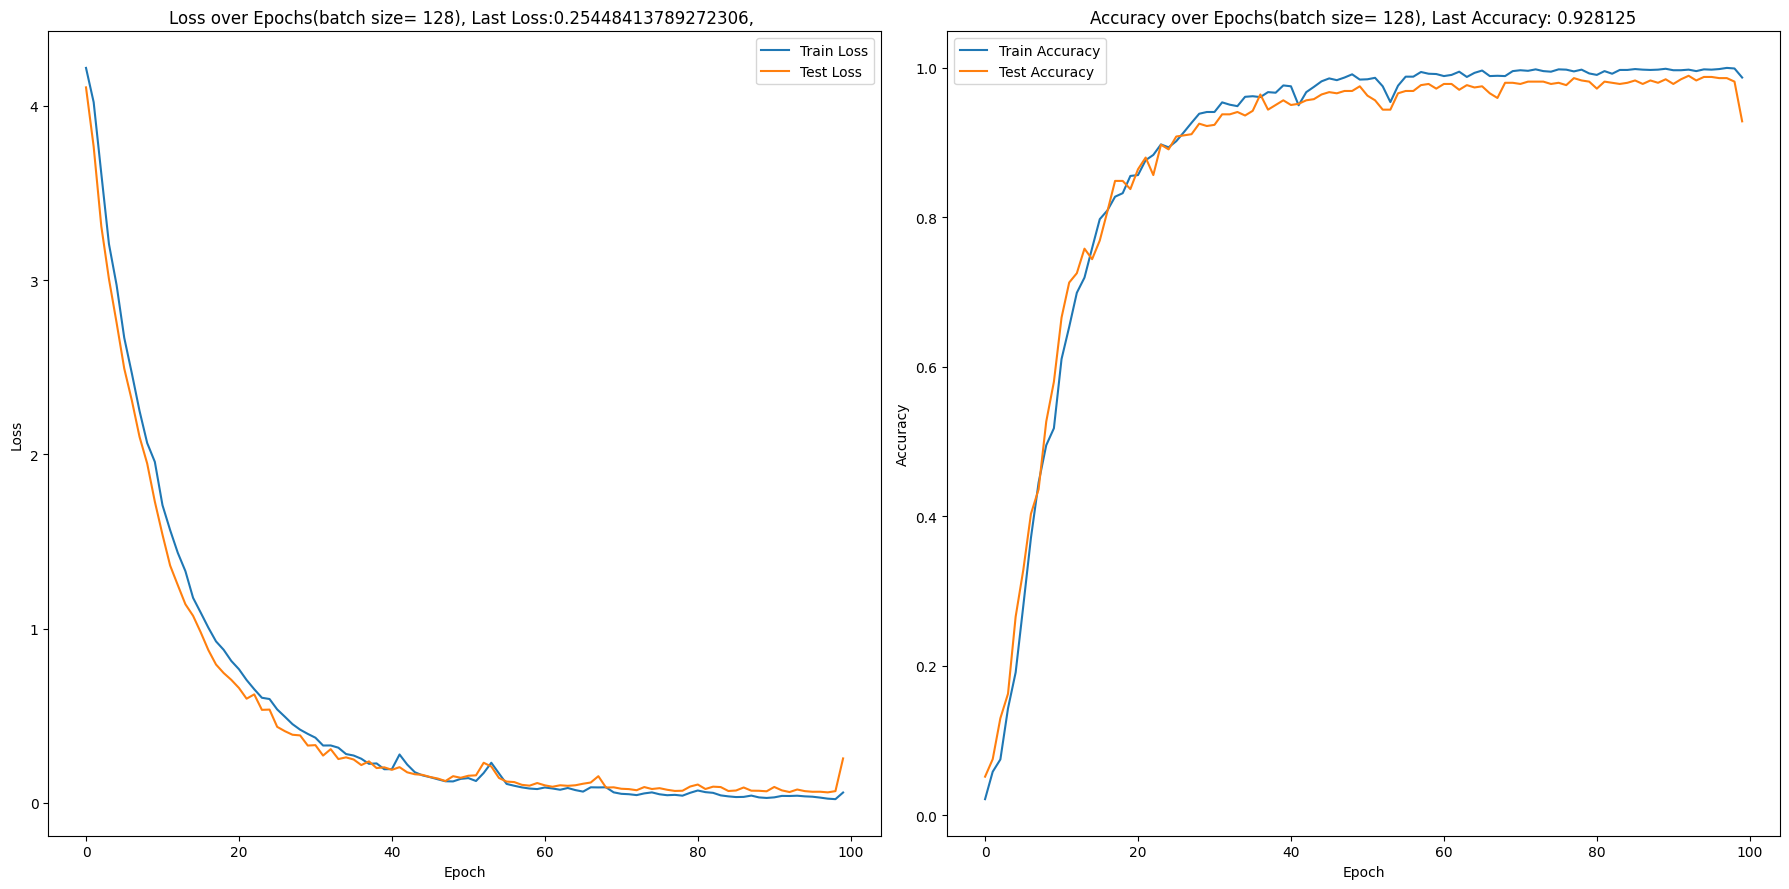

Fold 5
-------


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

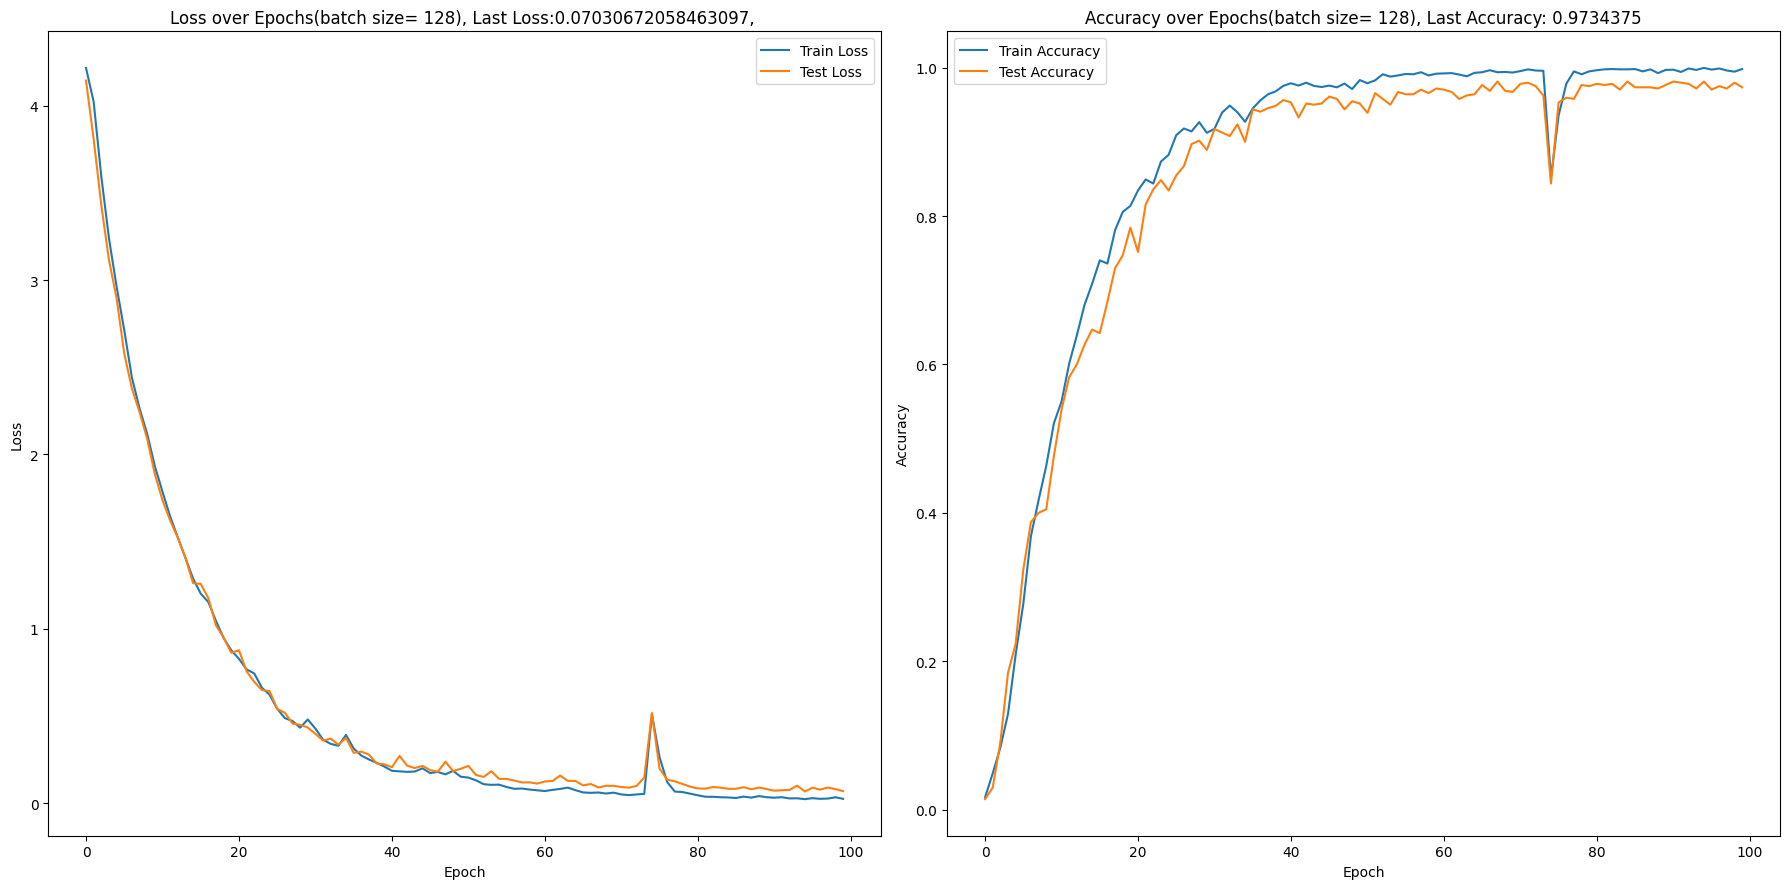

In [8]:
model= models.ConvoTransformer(prepare_datasets.lsa64class_names)

set_train.kfold_cross_validation(detections= lsa64['40fps'],
                                 labels= lsa64_labels['40fps'],
                                 class_names= prepare_datasets.lsa64class_names, 
                                 n_splits= 5, 
                                 batch_size= 128, 
                                 num_epochs= 100,
                                 model= model, 
                                 learning_rate= 0.0001,
                                 device= device)

In [6]:
class CustomLayerConductance(LayerConductance):
    def attribute(self, inputs, *args, **kwargs):
        print("Input to LayerConductance attribute method shape:", inputs.shape)
        result = super().attribute(inputs, *args, **kwargs)
        print("Output of LayerConductance attribute method shape:", result.shape)
        return result

def visualize_attributions(attributions, title="Attributions"):
    attributions = attributions.detach().cpu().numpy()  # Move tensor to CPU before converting to NumPy
    batch_size, seq_len, num_features = attributions.shape
    
    for i in range(batch_size):
        plt.figure(figsize=(12, 6))
        plt.imshow(attributions[i].T, cmap='viridis', aspect='auto', origin='lower')
        plt.colorbar()
        plt.title(f"{title} - Sample {i}")
        plt.xlabel("Sequence Length")
        plt.ylabel("Features")
        plt.xticks(range(0, seq_len, 5))  # Set ticks every 5 units
        plt.xlim(0, seq_len - 1)  # Set x-axis limits
        plt.yticks(range(0, num_features, 100))  # Set ticks every 10 units
        plt.ylim(0, num_features - 1)  # Set y-axis limits
        plt.show()

Input shape: torch.Size([1, 30, 1662])
Target label: [39]
Input to LayerConductance attribute method shape: torch.Size([1, 30, 1662])
Output of LayerConductance attribute method shape: torch.Size([1, 30, 1662])
Attribution shape: torch.Size([1, 30, 1662])


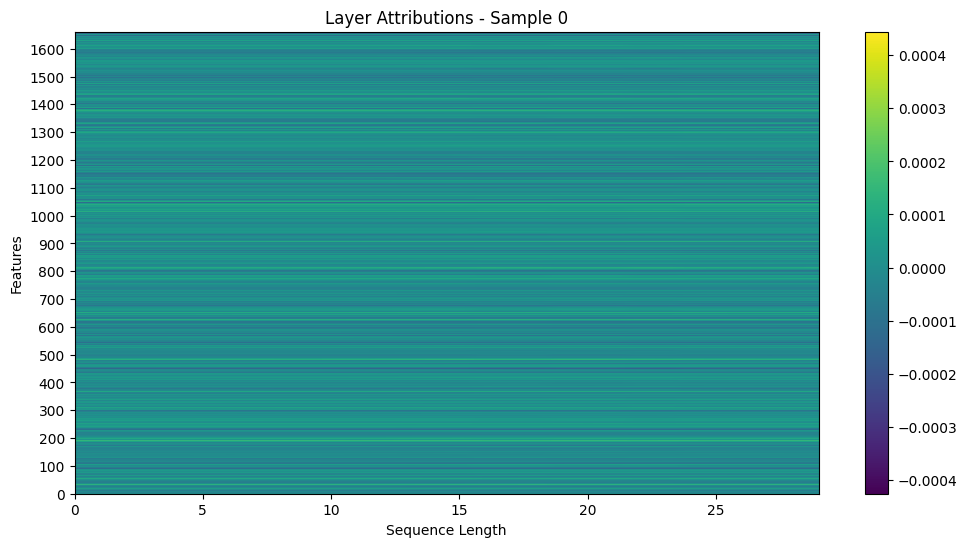

In [9]:
model= models.Transformer(prepare_datasets.lsa64class_names,30)

model.eval()
model.to(device)

X, y= preprocessing.convert(lsa64['30fps'], lsa64_labels['30fps'], prepare_datasets.lsa64class_names)

dataset= preprocessing.CustomDataset(X, y)
dataloader= DataLoader(dataset=dataset, batch_size= 1, num_workers=0, shuffle=True) 

input, target = next(iter(dataloader))
input, target = input.to(device), target.to(device)

print("Input shape:", input.shape) 
print("Target label:", target.tolist())  

layer_cond = CustomLayerConductance(model, model.transformer_encoder.layers[0])
cond_attributions = layer_cond.attribute(input, target=target.tolist())

print("Attribution shape:", cond_attributions.shape)

visualize_attributions(cond_attributions, title="Layer Attributions")

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

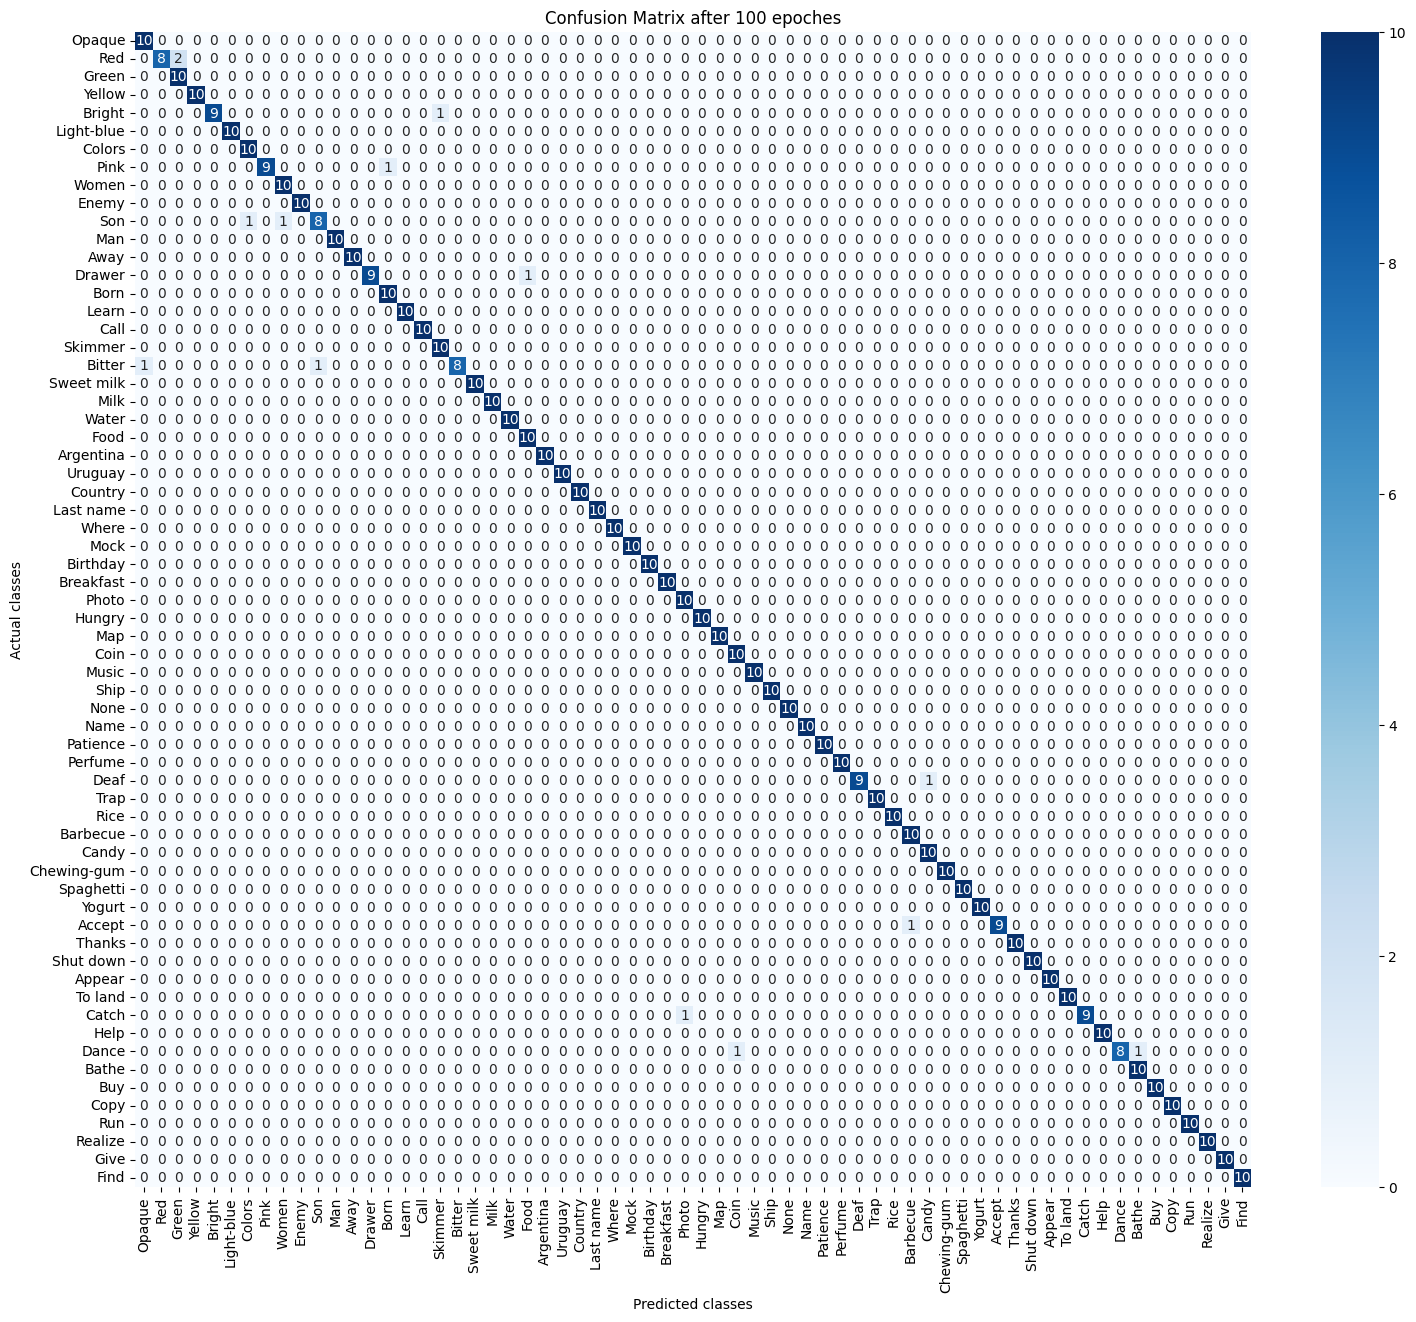

In [10]:
set_train.train_parameters(detections= lsa64['30fps'],
                           labels= lsa64_labels['30fps'],
                           class_names= prepare_datasets.lsa64class_names, 
                           test_size= 0.2, 
                           random_state= 42, 
                           batch_size= 128, 
                           num_epochs= 100,
                           model= model, 
                           learning_rate= 0.0001,
                           device= device)

Input shape: torch.Size([1, 30, 1662])
Target label: [39]
Input to LayerConductance attribute method shape: torch.Size([1, 30, 1662])
Output of LayerConductance attribute method shape: torch.Size([1, 30, 1662])
Attribution shape: torch.Size([1, 30, 1662])


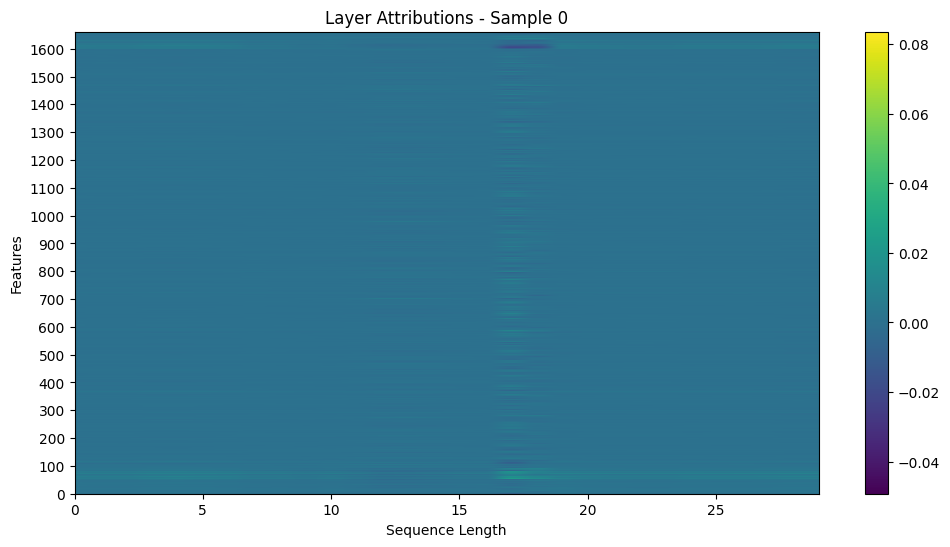

In [101]:
model.eval()
model.to(device)

input, target = next(iter(dataloader))
input, target = input.to(device), target.to(device)

print("Input shape:", input.shape) 
print("Target label:", target.tolist())  

layer_cond = CustomLayerConductance(model, model.transformer_encoder.layers[0])
cond_attributions = layer_cond.attribute(input, target=target.tolist())

print("Attribution shape:", cond_attributions.shape)

visualize_attributions(cond_attributions, title="Layer Attributions")

Input shape: torch.Size([1, 30, 1662])
Target label: [39]
Input to LayerConductance attribute method shape: torch.Size([1, 30, 1662])
Output of LayerConductance attribute method shape: torch.Size([1, 30, 1662])
Attribution shape: torch.Size([1, 30, 1662])


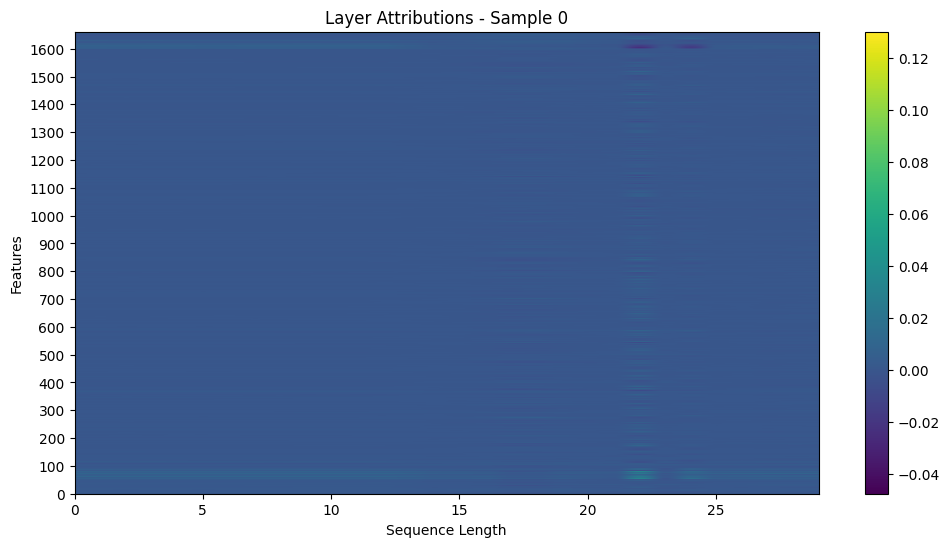

In [111]:
model.eval()
model.to(device)

input, target = next(iter(dataloader))
input, target = input.to(device), target.to(device)

print("Input shape:", input.shape) 
print("Target label:", target.tolist())  

layer_cond = CustomLayerConductance(model, model.transformer_encoder.layers[0])
cond_attributions = layer_cond.attribute(input, target=target.tolist())

print("Attribution shape:", cond_attributions.shape)

visualize_attributions(cond_attributions, title="Layer Attributions")

Input shape: torch.Size([1, 30, 1662])
Target label: [39]
Input to LayerConductance attribute method shape: torch.Size([1, 30, 1662])
Output of LayerConductance attribute method shape: torch.Size([1, 30, 1662])
Attribution shape: torch.Size([1, 30, 1662])


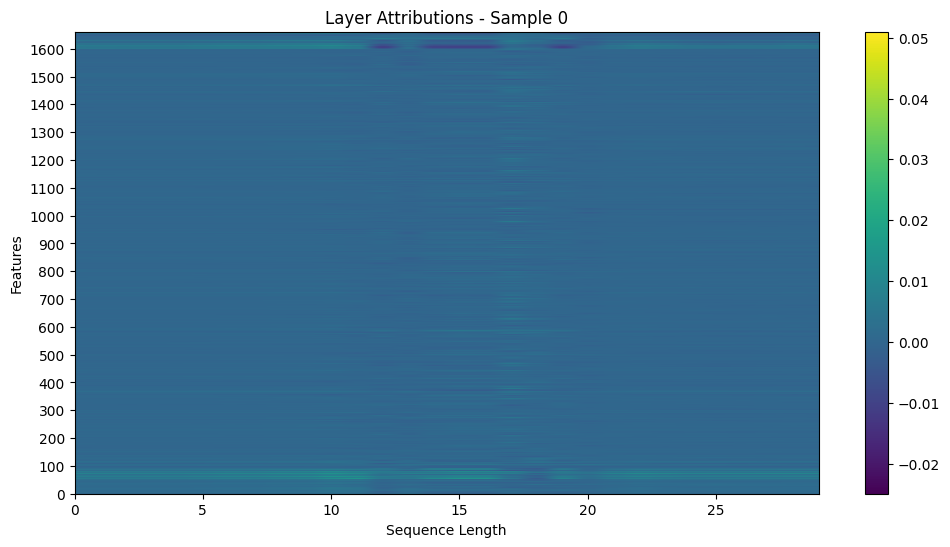

In [112]:
model.eval()
model.to(device)

input, target = next(iter(dataloader))
input, target = input.to(device), target.to(device)

print("Input shape:", input.shape) 
print("Target label:", target.tolist())  

layer_cond = CustomLayerConductance(model, model.transformer_encoder.layers[0])
cond_attributions = layer_cond.attribute(input, target=target.tolist())

print("Attribution shape:", cond_attributions.shape)

visualize_attributions(cond_attributions, title="Layer Attributions")